### YARN 기반 클러스터 모드에서의 Spark Application 제출
* Spark Application 개념의 이해에서 사용한 예제 데이터셋 사용

* spark_ex01/data 디렉토리의 mnm_dataset.csv를 HDFS에 업로드

In [ ]:
# 디렉토리 생성
$HADOOP_HOME/bin/hadoop fs -mkdir spark_ex01
$HADOOP_HOME/bin/hadoop fs -mkdir spark_ex01/data

# HDFS에 생성한 디렉토리에 mnm_dataset.csv 파일 업로드
$SPARK_HOME/bin/spark-submit --master yarn --deploy-mode client ~/spark_ex01/data/mnm_dataset.csv \
> spark_ex01/data

* 만약 mkdir: `hdfs://master:9000/user/ubuntu': No such file or directory의 오류가 발생하게 되면 user/ubuntu 디렉토리가 올바르게 생성이 되지 않아서 발생하는 오류이다.
* 앞서 /usr/ubuntu/spark-logs파일을 생성시에 sudo로 생성했다면 sudo를 제거하고 다시 생성해주면 해결이 된다.

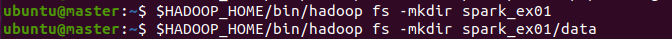

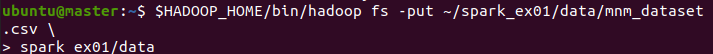

* Spark Application 제출: 클러스터 모드는 콘솔에 결과 출력이 안되므로 클라이언트 모드 선택

In [ ]:
# Spark Application 제출
$SPARK_HOME/bin/spark-submit --master yarn --deploy-mode client ~/spark_es01/mnmcount.py spark_ex01/data/mnm_dataset.csv

> --master yarn \      # cluster manager로 YARN 사용
> --deploy-mode client \         # 클라이언트 모드로 실행
> ~/spark_ex01/mnmcount.py \       # python 스크립트 파일 제출
> spark_ex01/data/mnm_dataset.csv     # HDFS에 업로드한 데이터 지정

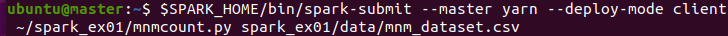

* 결과 확인: 콘솔을 통한 DataFrame 출력물 확인
* 이전에 rootLogger.level = info라인을 WARN으로 수정했기 때문에 로그메시지가 WARN레벨까지만 출력된다.

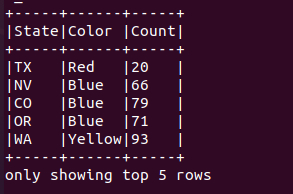

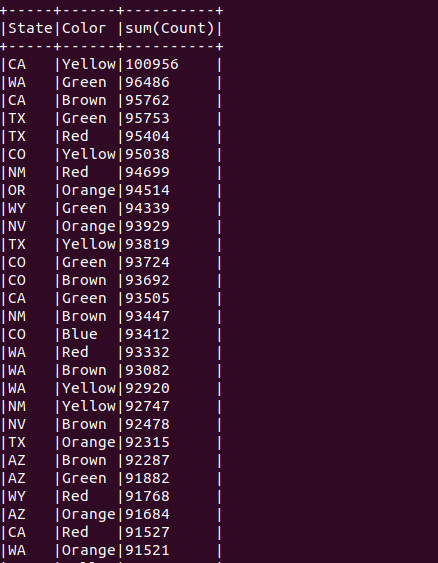

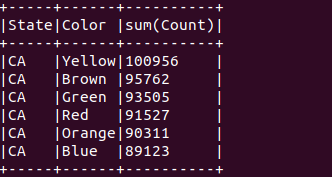

* 우분투 환경의 FireFox 브라우저에 'http://<master의 ip>:8088'을 입력하여 YARN의 웹 UI를 확인할 수 있다.

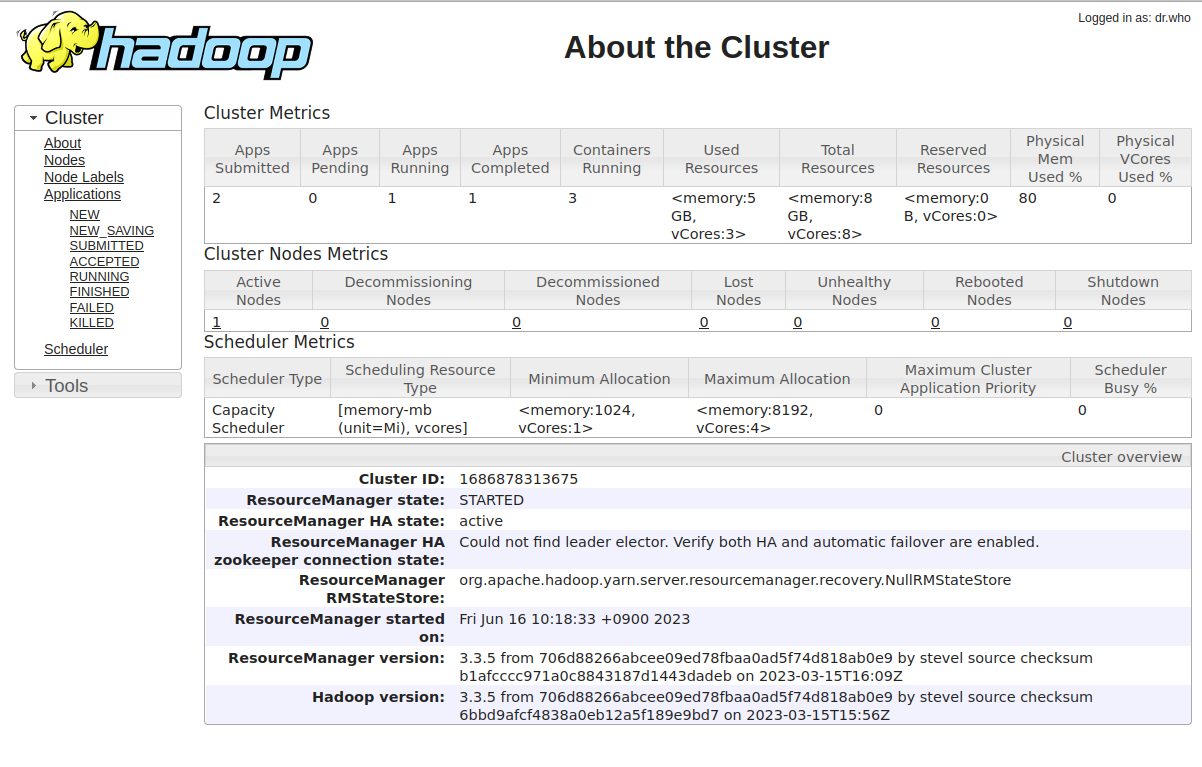

* Application 메뉴에서 제출한 application의 수행 상태, SPARK가 YARN과 잘 연동되었는지 여부 등을 확인 가능

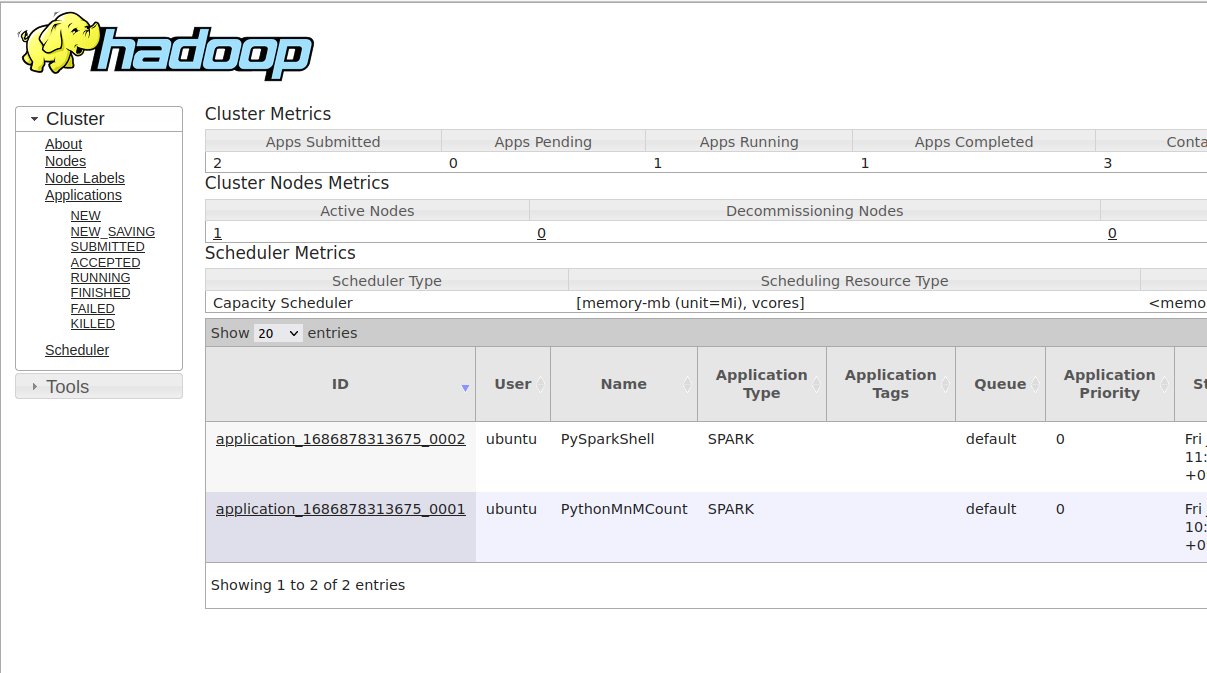

* 마찬가지로, pyspark가 올바르게 구동되는지 확인

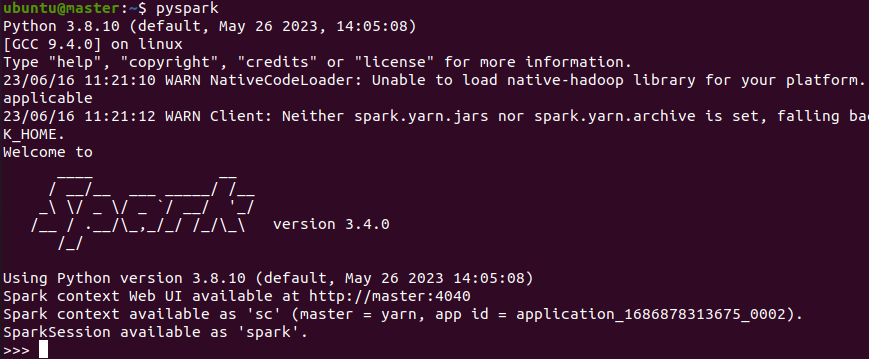

# Spark Streaming

## 1. Spark의 스트림 처리

* 스트림(Stream) 처리: 끝없이 들어오는 데이터 흐름을 연속적으로 처리하는 것
* 분산 스트림 처리 파이프라인은 일반적으로 다음과 같은 프로세스로 실행됨
    1. 데이터 소스(ex. 라이브 로그, 시스템 원격 측정 데이터, IoT 장치 데이터 등)로부터 스트리밍 데이터 수신
    2. 클러스터에서 스트림 처리 엔진을 통해 병렬로 데이터 처리력

### 전통적인 레코드 단위 처리 모델

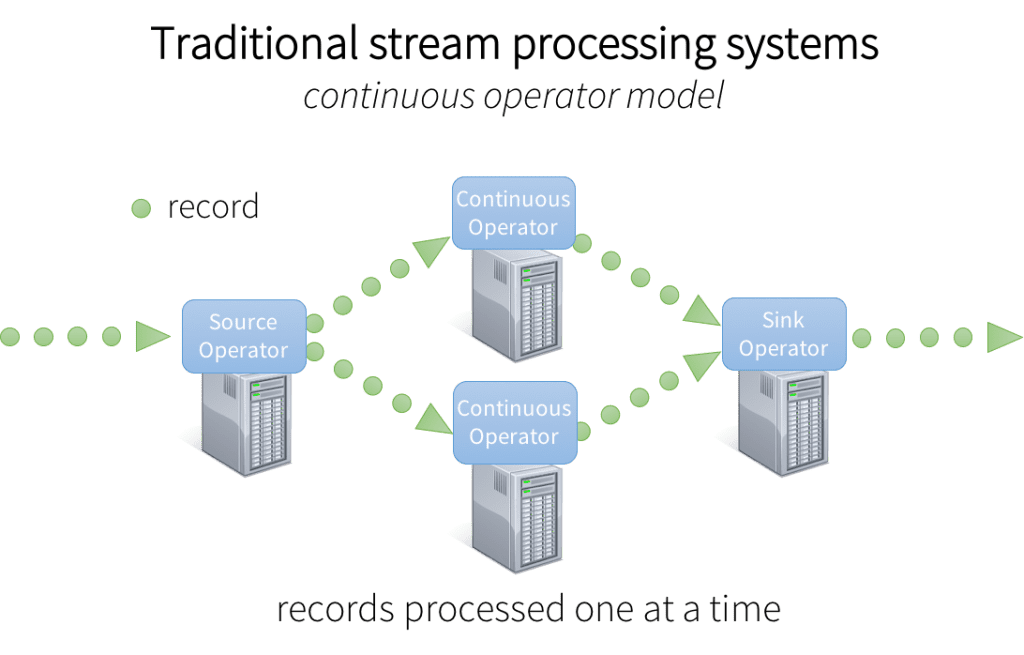

* 스트리밍 데이터 처리 파이프라인은 각 노드들의 지향성 그래프로 구성
* 각 노드에는 하나 이상의 Operator가 존재
* Source Operator를 통해 데이터 수신
* 각 Continuous Operator는 지속적으로 스트리밍 데이터 중 한번에 하나씩의 레코드만 받음<br>
-> 이를 처리하여 생성된 레코드를 그래프상의 다음 Operator로 전달
* Sink Operator를 통해 다운스트림 시스템으로 출력
* 이러한 처리 모델은 매우 짧은 응답시간을 달성할 수 있음, 하지만 특정 노드가 장애를 겪거나 다른 노드보다 느린 상황이 발생할 시 해결이 어려움

### 마이크로 배치 스트림 처리(DStream)

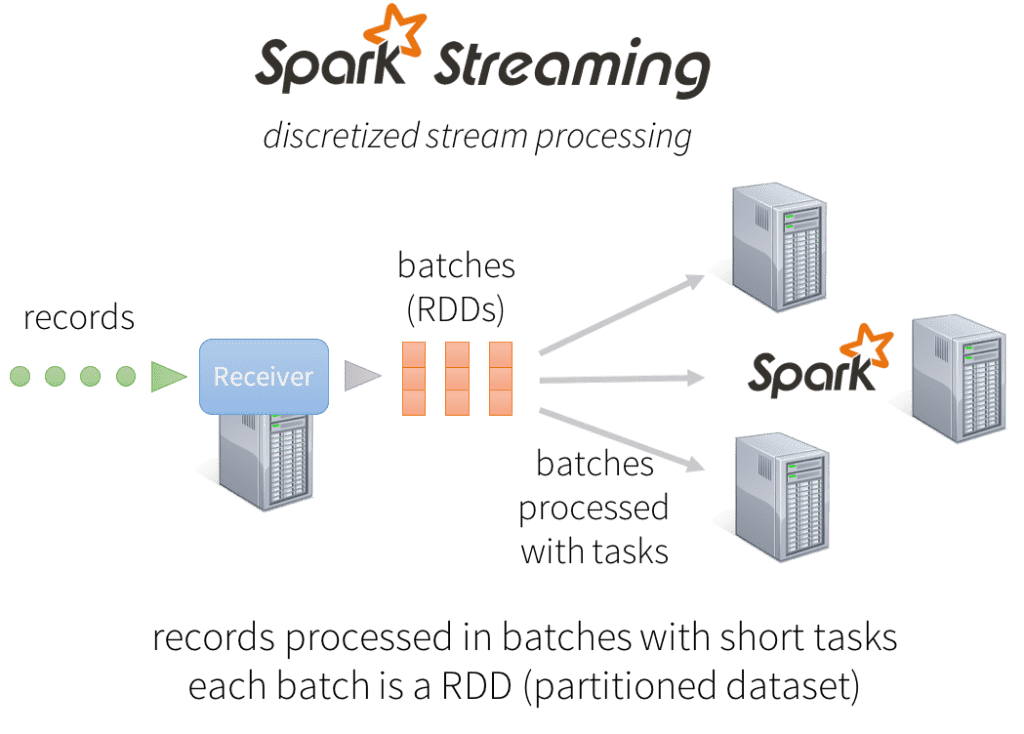

* 전통적 모델의 단점을 개선하고자 Spark는 마이크로 배티 스트림 처리(Micro-batch stream processing) 적용<br>
-> 스트리밍 처리를 아주 작은 맵리듀스 스타일 배치 처리 잡 형태로 쪼개어 작은 스트리밍 데이터 조각들에 대한 연속적인 처리를 수행
* Spark Streaming은 입수한 데이터를 잘게 쪼갠다.(ex. 1초 단위로 수행되는 마이크로 배티로 쪼갬)
* 각 마이크로 배치는 Spark 클러스터 내 노드들에 task로 쪼개져 실행됨
* 마이크로 배치 스트림 처리 모델을 통해 효과적인 장애 대응 가능
* 이 모델은 Spark RDD를 기반으로 작성되었으며, DStream이라고 부름
* DStream모델의 한계점
    - 배치/스트림 처리를 위한 단일 API의 부재하며 배치 잡을 스트리밍 잡으로 전환할 때, 개발자들이 코드를 명시적으로 재작성해야 한다.
    - 개발자들이 정확한 물리 계획을 직접 지정해야 하며, 이로 인해 자동화된 최적화가 힘듦

### 정형화 스트리밍(Structured Streaming Model)

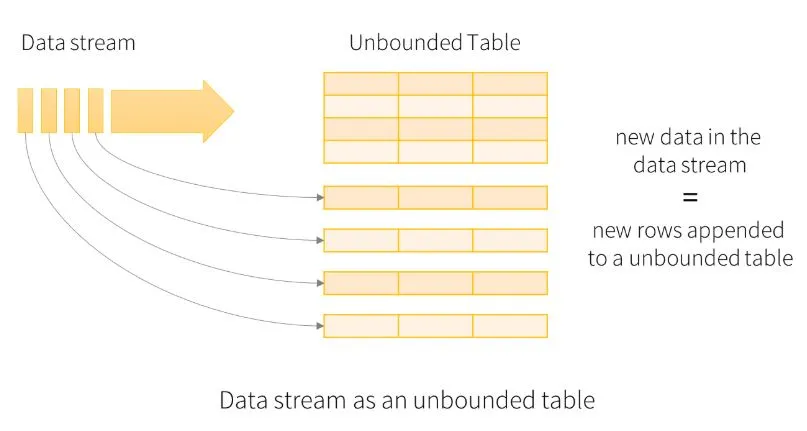

* DStream모델의 한계를 개선하기 위하여 등장
* 스트림 데이터를 위의 그림처럼 일련의 무한하게 연속적으로 데이터가 추가되는 테이블의 개념으로 간주<br>
-> 데이터 스트림에서 입수하는 모든 새로운 레코드는 무한 입력 테이블에 추가되는 새로운 행과 같다.

* 정형화 스트리밍은 모든 입력이 들어올 때마다 저장하는 것이 아니라, 트리거가 활동할 때 그동안 쌓인 입력을 저장

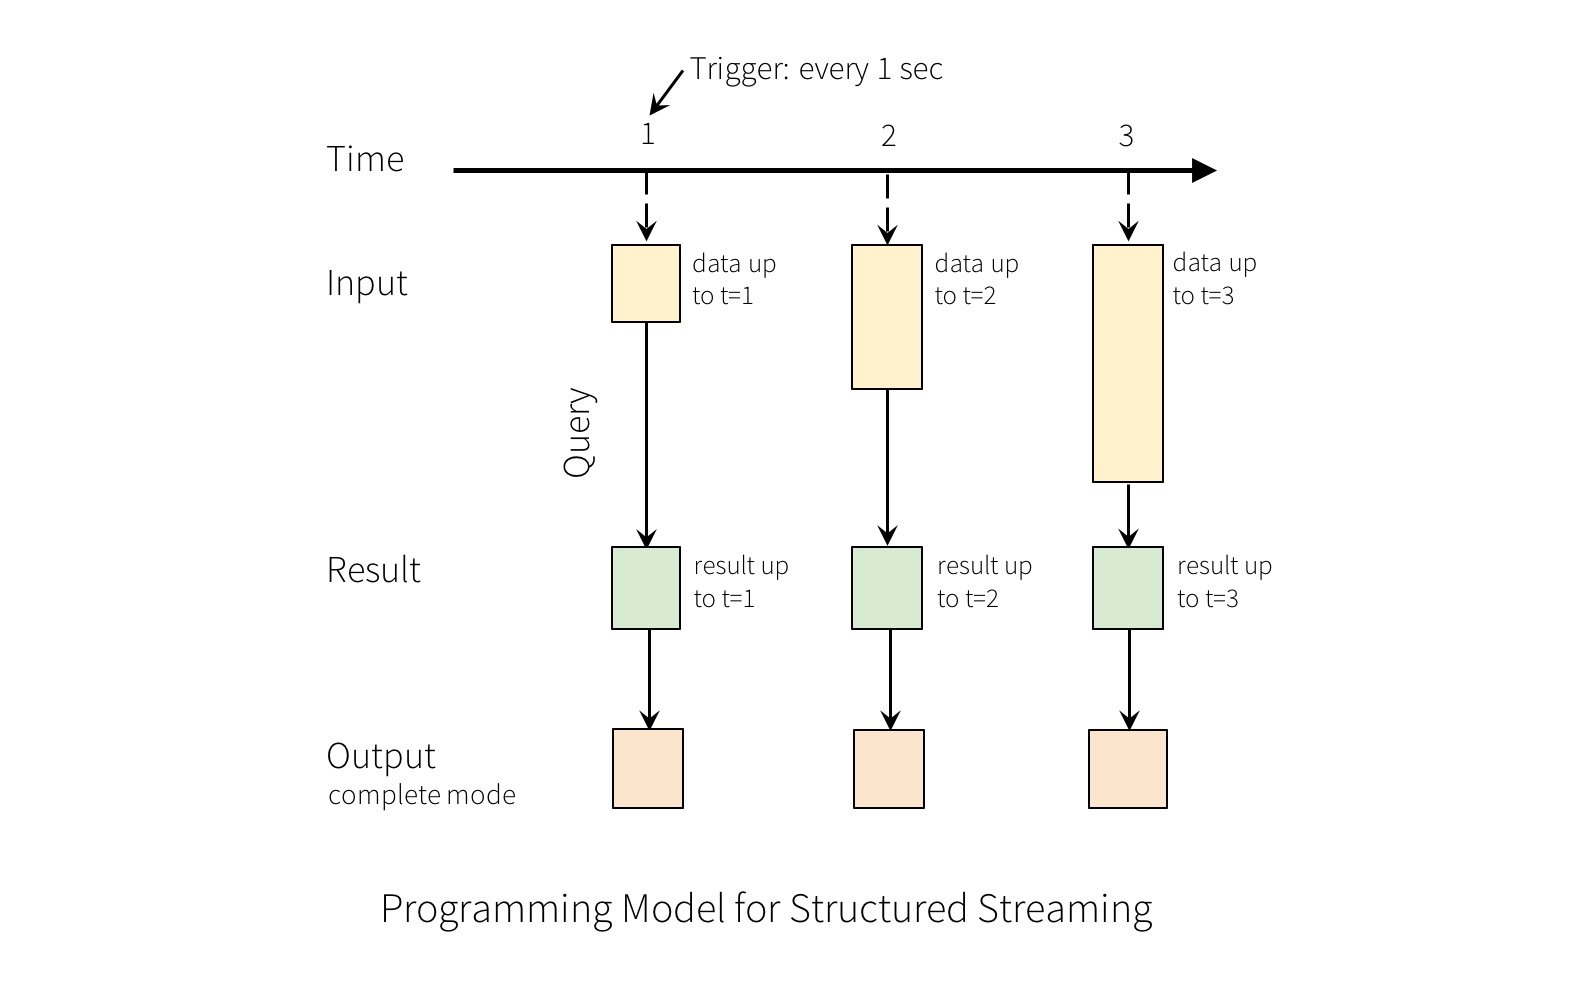

* 특정 시간 T가 될 때까지 정형화 스트리밍이 만들어내는 출력 결과는 T시간 동안의 모든 입력 데이터를 처리하여 저장한 정적인 일반테이블과 동일
* 정형화 스트리밍에서는 특정 테이블(Result)을 얻기 위하여 입력 테이블(Input)에 구조적 API의 배치 쿼리를 적용 가능하며, 이 경우 배치 쿼리가 자동으로 스트리밍 실행 계획으로 변환됨 -> 이를 증식화(Incrementalization)라고 한다.
* 정형화 스트리밍은 트리거가 발동될 때마다 새로운 데이터(입력 테이블의 새로운 행)가 있는지 체크하고 점진적으로 결과를 갱신/기록 -> Spark Streaming은 이를 위한 세 가지 Output모드를 제공
    - 추가(append) 모드
        - 지난 트리거 이후 새로 추가된 레코드만 출력 -> 즉, 이미 출력된 결과들은 변경되지 않음
        - 결과 테이블에 존재하는 기존 데이터들을 변경하지 않는 쿼리들에 대해서만 적용 가능
    - 갱신(update) 모드
        - 지난 트리거 이후 결과 테이블에서 변경된 레코드들만 출력<br>
        -> 즉, 이전 배치에서 이미 출력된 행이 현재 배치에서 변경되면, 이 변경된 행들만 출력
        - 특정 키에 대한 집계, 특정 행 필터링 등이 필요한 경우 사용
    - 전체(complete) 모드
        - 갱신된 전체 테이블 출력

## 2. 정형화 스트리밍 쿼리 기초

### 0단계: 실습 전 준비
* master에서 Spark Cluster를 구동한 후 pyspark에서 cluster 환경에 맞게 SparkSession 재정의

In [ ]:
# Spark 중지 및 Session 새로 정의
spark.stop()
spark = SparkSession.builder\
    .appName("SocketStreaming")\
    .master("yarn")\
    .config("spark.submit.deployMode", "client")\
    .getOrCreate()

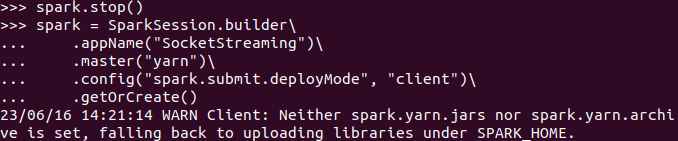

* worker01에서 9999포트를 소켓서버로 지정<br>
-> 추후 텍스트 스트림을 입력해야 하므로 입력 후 콘솔 창은 그대로 둬야 한다.

In [ ]:
# worker01에서 실행
# 소켓 서버 지정
nc -lk 9999

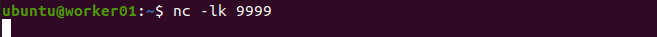

### 1단계: 입력 소스 지정(read)
* 고수준 API에서처럼 첫 단계는 스트리밍 소스로부터 데이터 프레임 지정<br>
: 실제로 스트리밍 쿼리가 동작할 때, 데이터를 읽어들이기 위하여 필요한 설정들을 정의

In [ ]:
# master에서 실행
# master:9999에서 개행문자로 행 구분되는 텍스트 데이터를 읽어
# 무한 테이블 형태의 DataFrame인 lines 생성
lines = spark\
    .readStream.format("socket")\
    .option("host", "worker01")\
    .option("port", "9999")\
    .load()

* readStream: 스트리밍 소스로부터 DataStreamReader 생성, DataStreamReader는 DataFrameReader와 동일한 함수들을 대부분 가지고 있으므로 고수준 API와 유사한 방식으로 사용 가능
* format("socket"): TCP/IP 소켓에서 바로 데이터 송신<br>
    - socket은 테스트 및 디버깅 용도로 사용
    - Spark는 socket이외에도 다양한 소스에서 스트리밍 데이터를 가져올 수 있다.

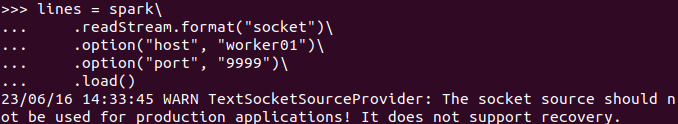

### 2단계: 데이터 변형
* 무한한 형태의 DataFrame 생성 후 구조적 API에서 사용하는 배치 쿼리를 활용하여 데이터를 개별 단어로 나눈다던지, word count를 하는 등 일상적인 데이터프레임 연산을 수행 가능

In [ ]:
from pyspark.sql.functions import *

# words라는 DataFrame을 생성하여 텍스트스크림 lines에서 value컬럼의 값(각 텍스트 라인)을 공백(\\s)으로 분리 한 후
# words라는 별칭으로 컬럼 생성
words = lines.select(split(col("value"), "\\s").alias("word"))

# words DataFrame에서 컬럼 word를 기준으로 빈도수 집계
counts = words.groupBy("word").count()

* counts변수는 단어 세기 프로그램을 나타내는 스트리밍 데이터 프레임(무제한의 스트리밍 데이터가 계속 들어오는 데이터 프레임)
* 한번 스트리밍 쿼리가 시작되면 스트리밍 입력이 지속적으로 처리되면서 계산 수행

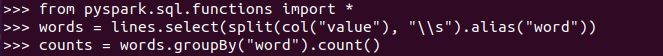

### 3단계: 출력 싱크와 모드 결정(write)
* 데이터 변형 후 DataFrame.WriteStream을 사용하여 처리된 출력데이터가 어떻게 사용될 지 정의할 수 있다.

In [ ]:
writer = counts.writeStream.format("console").outputMode("complete")

* 출력 방식(어디에 어떻게 출력 결과가 쓰일 지)과 처리 방식(어떻게 데이터가 처리되고, 장애 시 어떻게 복구되는지) 지정 가능
* 출력 방식 = console
    - 출력 스트리밍 싱크에 콘솔 지정 -> 처리된 스트리밍에 데이터가 콘솔에 출력됨
* 처리 방식 = complete
    - 위에서 설명한 Spark Streaming의 세가지 output mode중 선택(예시의 경우 전체(complete)모드)
    - 예시에서 진행하는 word count query는 이번에 기록된 레코드도 집계해 업데이트하므로 기존의 레코드를 변경하지 않는 추가(append)모드는 사용할 수 없다.

### 4단계: 처리 세부사항 지정
* 쿼리 시작 전 마지막 단계는 데이터를 어떻게 처리할 것인지 세부 사항을 지정하는 것

In [ ]:
# 새로운 터미널을 열어서 다음을 실행
# 경로 이동
cd /usr/local/hadoop/bin

# HDFS의 /usr/ubuntu에 checkpoint_wc 디렉토리 생성
./hadoop fs -mkdir checkpoint_wc

In [ ]:
checkpointDir = "hdfs://master:9000/user/hadoop/checkpoint_wc"
writer2 = writer\
    .trigger(processingTime="1 second")\
    .option("checkpointLocation", checkpointDir)

* trigger: 새롭게 추가된 스트리밍 데이터를 발견하고 처리하는 동작이 언제 발동되는지 설정
    - 기본(default): trigger가 명시적으로 지정되지 않았다면, 스트리밍 쿼리는 앞선 마이크로 배치가 완료되자마자 다음 마이크로 배치가 실행되는 곳부터 데이터를 실행
    - 트리거 간격에 따른 처리 시간
        - ProcessingTime 파라미터를 통해 명시적으로 간격 지정 가능
        - 이 경우 쿼리는 설정한 간격에 따라 마이크로 배치 실행
    - 일회 실행(once): 스트리밍 쿼리는 정확히 하나의 마이크로 배치만을 실행 -> 하나의 배치에서 모든 새로운 데이터를 처리하고 멈춘다.
    - 연속(continuous)<br>
        - 스트리밍 쿼리가 마이크로 배치 단위 대신, 연속적으로 데이터를 처리하는 실험 모드(Spark 3.0에서부터 도입)
        - DataFrame 연산 중 일부 몇 가지만 이 모드를 사용 가능
        - 마이크로 배치 트리거에 비해 매우 빠른 응답성 제공
 
 * checkpointLocation
     - HDFS와 호환되는 파일 시스템 위에 스트리밍 쿼리가 진행중인 데이터 상황을 저장하는 디렉토리
     - 실패 시 실패한 쿼리 마지막 지점에서 재시작 할 수 있게 하는 용도로 사용

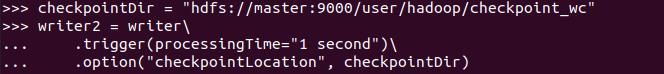

### 5단계: 쿼리 시작
* 아래 코드와 같이 쿼리 실행

In [ ]:
# 쿼리 실행
streamingQuery = writer2.start()

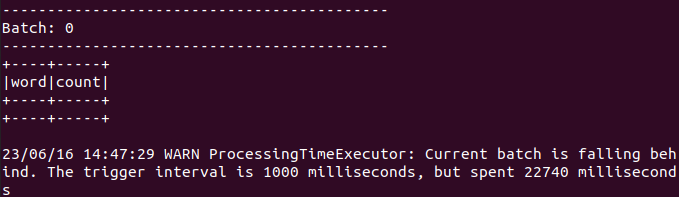

* start() 실행 시 객체만 반환하고 끝날 수 있다. -> 이 경우, 활성화된 쿼리가 종료될 때 까지 계속 실행되기를 원한다면 awaitTermination() 사용

In [ ]:
# 쿼리가 계속해서 실행되지 않는 경우
streamiingQuery.awaitTermination()

* 소켓 서버(worker01)에 텍스트를 입력하면 amster의 스트리밍 쿼리가 trigger에 따라 이를 처리하고 결과 테이블 출력

In [ ]:
# worker01에서 텍스트 입력
apache hadoop

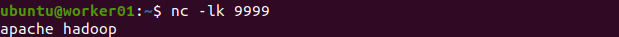

* master에서 스트리밍 결과 확인

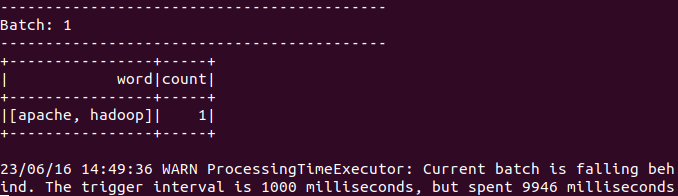

In [ ]:
# worker01에서 텍스트 입력
apache kafka

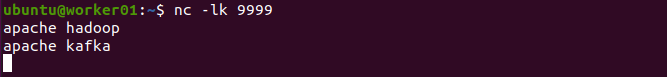

* master에서 스트리밍 결과 확인

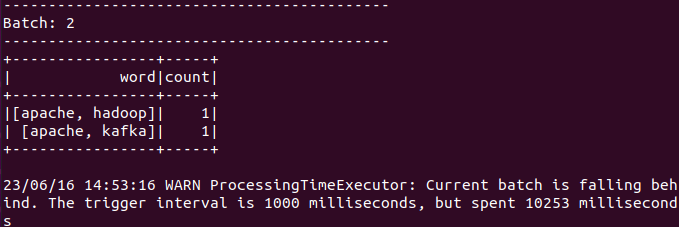

In [ ]:
# worker01에서 텍스트 입력
changmin jeon

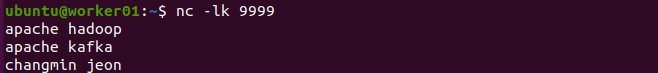

* master에서 스트리밍 결과 확인

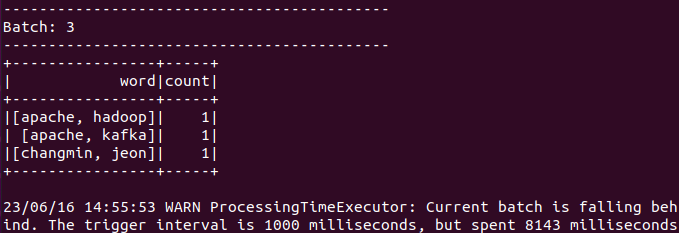

In [ ]:
# worker01에서 텍스트 입력
# 중복 단어를 입력
apache hadoop

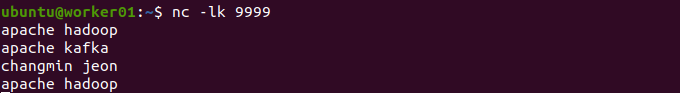

* master에서 스트리밍 결과 확인
* 중복단어가 입력된 경우 count가 1씩 올라가는 것을 알 수 있다.

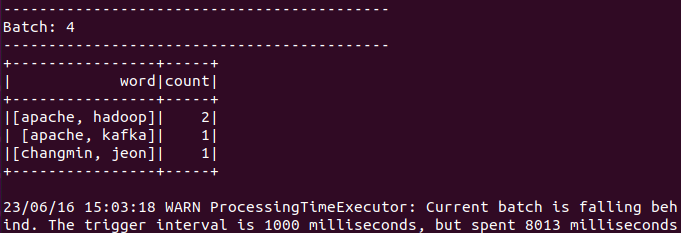

### 실행중인 스트리밍 쿼리 내부
* 위의 스트리밍 쿼리는 다음과 같은 순서로 구동된다.

1. Spark SQL이 스트리밍 데이터에 대하여 그 특성에 따라 연속적/효과적으로 실행 가능한지 확인하기 위해 논리 계획을 분석 및 최적화
2. Spark SQL은 아래의 루프를 백그라운드 스레드를 통하여 반복적으로 실행
    1. 설정된 트리거 간격마다 스레드는 새 데이터가 있는지 스트리밍 소스를 확인
    2. 새 데이터가 있으면 마이크로 배치로 실행
        - 최적화된 논리 계획을 바탕으로 최적화된 실행 계획 생성
        - 스트리밍 소스에서 실행 계획에 따라 새 데이터를 읽어와 점진적으로 업데이트된 결과 산출
        - 설정된 출력 모드에 따라 결과를 싱크에 출력
    3. 모든 마이크로 배치 내 지정된 체크포인트 위치에서 쿼리가 필요할 시 정확한 범위를 새로 처리할 수 있도록 처리 데이터 범위와 연관된 상태들을 저장
3. 이 루프는 다음과 같은 이유로 질의가 종료되기 전까지 계속 동작
    1. 질의에서 오류 발생
        - 처리상 오류 발생
        - 클러스터 장애 발생 등
    2. StreamingQuery.stop() 호출
    3. 트리거가 once로 설정된 경우 쿼리는 모든 가능한 데이터를 처리하는 한번의 마이크로 배치 실행 후 종료